# Will it be delayed?

Everyone who has flown has experienced a delayed or cancelled flight. Both airlines and airports would like to improve their on-time performance and predict when a flight will be delayed or cancelled several days in advance. You are being hired to build a model that can predict if a flight will be delayed. To learn more, you must schedule a meeting with your client (me). To schedule an appointment with your client, send an event request through Google Calendar for a 15 minute meeting. Both you and your project partner must attend the meeting. Come prepared with questions to ask your client. Remember that your client is not a data scientist and you will need to explain things in a way that is easy to understand. Make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

For this project you must go through most all steps in the checklist. You must write responses for all items as done in the homeworks, however sometimes the item will simply be "does not apply". Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Some changes to the checklist:

* Do not do the final part (launching the product).
* Your presentation will be done as information written in this document in a dedicated section (no slides or anything like that). It should include high-level summary of your results (including what you learned about the data, the "accuracy" of your model, what features were important, etc). It should be written for your client, not your professor or teammates. It should include the best summary plots/graphics/data points.
* The models and hyperparameters you should consider during short-listing and fine-tuning will be released at a later time (dependent on how far we get over the next two weeks).
* Data retrieval must be automatic as part of the code (so it can easily be re-run and grab the latest data). Do not commit any data to the repository.
* Your submission must include a pickled final model along with this notebook.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Frame the Problem and Look at the Big Picture
=============================================

1. **Define the objective in business terms:** Developing a machine learning model to predict delays and cancellations and their types 7 days in advance. Customers satisfaction would increase if delays and cancellations could be predicted earlier. This would also cut costs and better prepare airports.
2. **How will your solution be used?** Will be used to predict delays and cancellations to better prepare customers and airports and save money. 
3. **What are the current solutions/workarounds (if any)?** Manually look at weather, historical data, and quick decision making. Delays are known when they occur and not as far in advance to be useful.
4. **How should you frame this problem?** It is a Supervised Multiclassification problem for delays and cancellations and the delays length and the causes of delays and cancellations.
5. **How should performance be measured? Is the performance measure aligned with the business objective?** Accuracy, precision, ROC-AUC, f1 score and recall with focus on recall.
6. **What would be the minimum performance needed to reach the business objective?** Asked for 25% increase would be great.
7. **What are comparable problems? Can you reuse (personal or readily available) experience or tools?** MNIST and Iris data sets would be useful for experience for classification and multiclass.
8. **Is human expertise available?** Flights can be somewhat predictably predicted but not too great.
9. **How would you solve the problem manually?** Look at trends and weather data. Check for holidays, and how full an airport is. Check if an inbound plane is late as this leads to the next flight being delayed most likely.
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** Weather causes delays the most. Some flight paths are more likely to be delayed than others. Some carriers are more likely to be delayed or cancelled as well as some airports are more likely too.

Get the Data
============

1. **List the data you need and how much you need:**
    - Flight Delays and Cancellation Data from 2023-2024
    - Weather Data across the country from 2023-2024
2. **Find and document where you can get that data:**
    - The data is available in https://www.transtats.bts.gov/tables.asp?QO_VQ=EFD&QO_anzr=Nv4yv0r from Jan 2023-Dec 2024
    - open-meteo.com has all weather data needed
3. **Get access authorizations**:
   - Flight data is publically available
   - The weather data is publically available (for non-commercial use, in the real we would need to pay for the weather data to use it commercially)
4. **Create a workspace**: This notebook.
5. **Get the data**: 
    - Download all data from the website month by month and combine them into one.
    - Can get the weather data using the open-meteo.com API
6. **Convert the data to a format you can easily manipulate**:
   - The data is in several CSV files. Would be nicer to have them all in one csv file.
   - The weather data is in a relatively small CSV file.
   - We will create a merged dataset that is ready to load from the two sources.

In [3]:
data = pd.read_csv('cleaned_data.csv')

/var/folders/gy/3h3chr9d34xfxb9qbx03m8ww0000gp/T/ipykernel_46811/1299969751.py:1: DtypeWarning: Columns (11,13,57) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('cleaned_data.csv')


In [ ]:
def split_data(data):
    """
    Split the data into a training and testing set
    """
    return train_test_split(data, test_size=0.1, random_state=42)

train_set, test_set = split_data(data)

In [ ]:
# Save the datasets to parquet files to the directory
train_set.to_parquet('train_set.parquet')
test_set.to_parquet('test_set.parquet')

In [ ]:
# This will rename or variable to make things easier while also freeing up memory by deleting the original data
# The original is still available on disk (so we are indeed working with a copy already)
if 'train_set' in locals():
    data = train_set
    del train_set, test_set # to free up memory
else:
    data = pd.read_parquet('train_set.parquet')

Explore the Data
=============

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825707 entries, 0 to 14825706
Data columns (total 73 columns):
 #   Column                                              Dtype  
---  ------                                              -----  
 0   Year                                                int64  
 1   Quarter                                             int64  
 2   Month                                               int64  
 3   DayofMonth                                          int64  
 4   DayOfWeek                                           int64  
 5   FlightDate                                          object 
 6   Marketing_Airline_Network                           object 
 7   Operated_or_Branded_Code_Share_Partners             object 
 8   DOT_ID_Marketing_Airline                            int64  
 9   IATA_Code_Marketing_Airline                         object 
 10  Flight_Number_Marketing_Airline                     float64
 11  Originally_Scheduled_Code_Share_Air

In [5]:
data.describe()

,Year,Quarter,Month,DayofMonth,DayOfWeek,DOT_ID_Marketing_Airline,Flight_Number_Marketing_Airline,DOT_ID_Originally_Scheduled_Code_Share_Airline,Flight_Num_Originally_Scheduled_Code_Share_Airline,DOT_ID_Operating_Airline,...,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime
count,1.482571e+07,1.482571e+07,1.482571e+07,1.482571e+07,1.482571e+07,1.482571e+07,1.482571e+07,1603.000000,1603.000000,1.482571e+07,...,1.482571e+07,1.482571e+07,2.995616e+06,2.995616e+06,2.995616e+06,2.995616e+06,2.995616e+06,102229.000000,102210.000000,102210.000000
mean,2.023509e+03,2.528918e+00,6.586377e+00,1.577153e+01,3.983661e+00,1.982673e+04,2.551421e+03,20340.041173,5161.464754,1.996517e+04,...,8.066236e+02,3.700077e+00,2.489971e+01,4.090163e+00,1.300443e+01,1.314020e-01,2.884685e+01,1343.073384,40.823608,39.907553
std,4.999182e-01,1.106852e+00,3.403419e+00,8.781058e+00,2.007278e+00,2.825329e+02,1.710155e+03,123.628984,1054.977257,3.748050e+02,...,5.922690e+02,2.325704e+00,7.658620e+01,3.370453e+01,3.139895e+01,3.370272e+00,6.458379e+01,513.825412,35.809893,33.997188
min,2.023000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.939300e+04,1.000000e+00,20046.000000,3068.000000,1.939300e+04,...,1.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000
25%,2.023000e+03,2.000000e+00,4.000000e+00,8.000000e+00,2.000000e+00,1.979000e+04,1.154000e+03,20378.000000,4121.000000,1.979000e+04,...,3.730000e+02,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,901.000000,18.000000,18.000000
50%,2.024000e+03,3.000000e+00,7.000000e+00,1.600000e+01,4.000000e+00,1.980500e+04,2.233000e+03,20378.000000,5749.000000,1.993000e+04,...,6.490000e+02,3.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1353.000000,30.000000,30.000000
75%,2.024000e+03,4.000000e+00,1.000000e+01,2.300000e+01,6.000000e+00,1.997700e+04,3.777000e+03,20398.000000,6095.000000,2.036800e+04,...,1.045000e+03,5.000000e+00,2.200000e+01,0.000000e+00,1.700000e+01,0.000000e+00,3.300000e+01,1750.000000,50.000000,49.000000
max,2.024000e+03,4.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,2.043600e+04,9.887000e+03,20500.000000,6378.000000,2.050000e+04,...,5.095000e+03,1.100000e+01,5.764000e+03,2.419000e+03,2.700000e+03,1.460000e+03,3.581000e+03,2400.000000,423.000000,423.000000


In [6]:
data.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,Duplicate
0,2023,1,1,22,7,2023-01-22,B6,B6,20409,B6,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,2023,1,1,22,7,2023-01-22,B6,B6,20409,B6,...,5,39.0,0.0,1.0,0.0,14.0,NaN,NaN,NaN,N
2,2023,1,1,22,7,2023-01-22,B6,B6,20409,B6,...,5,7.0,0.0,16.0,0.0,0.0,1713.0,6.0,6.0,N
3,2023,1,1,22,7,2023-01-22,B6,B6,20409,B6,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,2023,1,1,22,7,2023-01-22,B6,B6,20409,B6,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


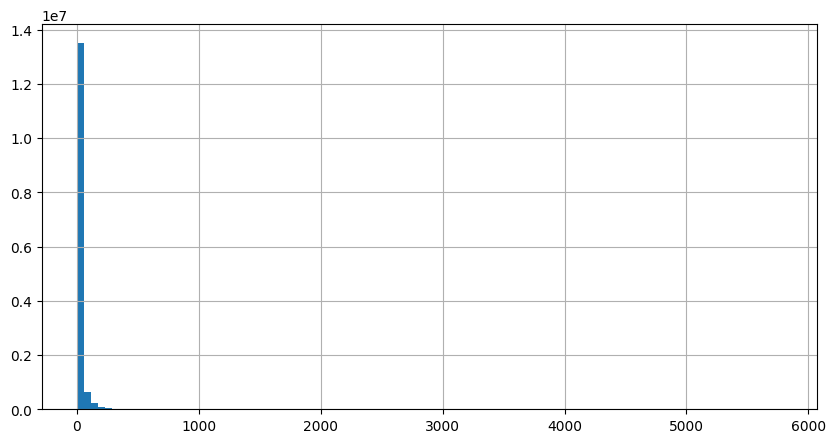

In [65]:
data['ArrDelayMinutes'].hist(bins=100, figsize=(10, 5))
plt.show()

Outliers in 6000 minutes seem impossible or incorrect. Log normal distribution

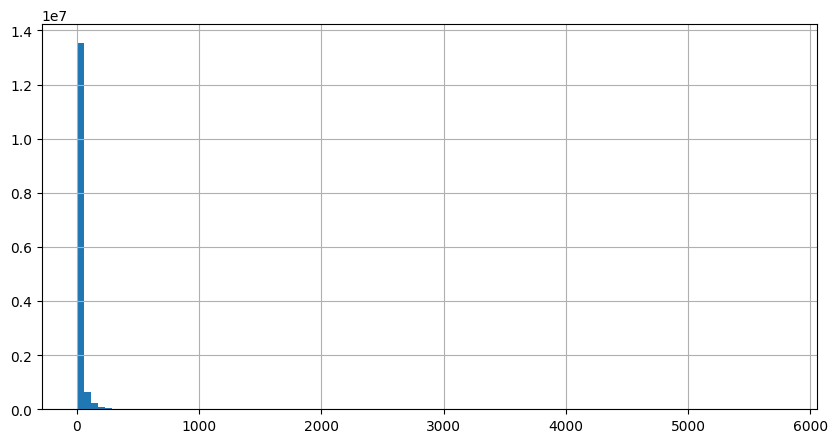

In [8]:
data['DepDelayMinutes'].hist(bins=100, figsize=(10, 5))
plt.show()

Log normal has outliers that seem fake, incorrect, or were cancels instead of delays. 100 hour delays is ridiculous.

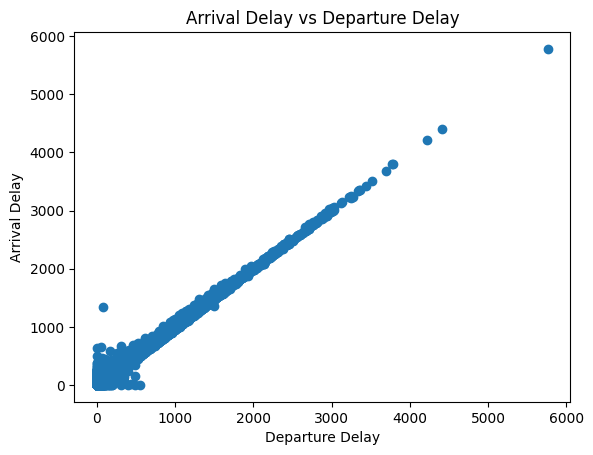

In [9]:
#scatter plot of arrival delay vs departure delay
plt.scatter(data['DepDelayMinutes'], data['ArrDelayMinutes'])
plt.xlabel('Departure Delay')
plt.ylabel('Arrival Delay')
plt.title('Arrival Delay vs Departure Delay')
plt.show()

Have a very high correlation almost exactly the same arrival delay as departure delay which makes sense.

In [33]:
data['MinorArrDelays'] = ((data['ArrDelayMinutes'] >= 15) & (data['ArrDelayMinutes'] < 60)).astype(int)
data['MinorDepDelays'] = ((data['DepDelayMinutes'] >= 15) & (data['DepDelayMinutes'] < 60)).astype(int)
data['MajorArrDelays'] = ((data['ArrDelayMinutes'] >= 60) & (data['ArrDelayMinutes'] < 180)).astype(int)
data['MajorDepDelays'] = ((data['DepDelayMinutes'] >= 60) & (data['DepDelayMinutes'] < 180)).astype(int)
data['ExtremeArrDelays'] = (data['ArrDelayMinutes'] >= 180).astype(int)
data['ExtremeDepDelays'] = (data['DepDelayMinutes'] >= 180).astype(int)
data['TotalArrDelays'] = data['MinorArrDelays'] + data['MajorArrDelays'] + data['ExtremeArrDelays']
data['TotalDepDelays'] = data['MinorDepDelays'] + data['MajorDepDelays'] + data['ExtremeDepDelays']
data['TotalDelays'] = data['TotalArrDelays'] + data['TotalDepDelays']
data['TotalDelays'] = data['TotalDelays'].replace(2, 1)

In [32]:
data['TotalDelays'].value_counts()

TotalDelays
0    11231541
1     3594166
Name: count, dtype: int64

In [29]:
data['TotalDepDelays'].value_counts()

TotalDepDelays
0    11850638
1     2975069
Name: count, dtype: int64

In [30]:
data['TotalArrDelays'].value_counts()

TotalArrDelays
0    11830088
1     2995619
Name: count, dtype: int64

Most delays are arrival delays which means that more have issues after department because if a flight is leaving late it will more than likely arrive late too.

In [11]:
data['MinorArrDelays'].value_counts()

MinorArrDelays
0    12866196
1     1959511
Name: count, dtype: int64

In [12]:
data['MinorDepDelays'].value_counts()

MinorDepDelays
0    12899055
1     1926652
Name: count, dtype: int64

In [13]:
data['MajorArrDelays'].value_counts()

MajorArrDelays
0    13992909
1      832798
Name: count, dtype: int64

In [14]:
data['MajorDepDelays'].value_counts()

MajorDepDelays
0    13984272
1      841435
Name: count, dtype: int64

In [15]:
data['ExtremeArrDelays'].value_counts()

ExtremeArrDelays
0    14622397
1      203310
Name: count, dtype: int64

In [16]:
data['ExtremeDepDelays'].value_counts()

ExtremeDepDelays
0    14618725
1      206982
Name: count, dtype: int64

All relatively similar amounts between Departing and Arriving but Arriving always has more.

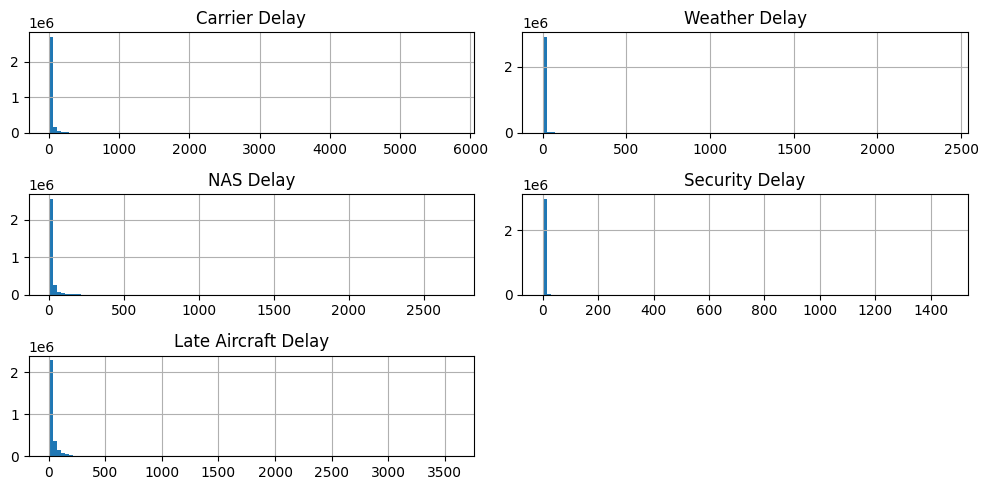

In [17]:
#Subplot all of these graphs
plt.figure(figsize=(10, 5))
plt.subplot(3, 2, 1)
data['CarrierDelay'].hist(bins=100)
plt.title('Carrier Delay')
plt.subplot(3, 2, 2)
data['WeatherDelay'].hist(bins=100)
plt.title('Weather Delay')
plt.subplot(3, 2, 3)
data['NASDelay'].hist(bins=100)
plt.title('NAS Delay')
plt.subplot(3, 2, 4)
data['SecurityDelay'].hist(bins=100)
plt.title('Security Delay')
plt.subplot(3, 2, 5)
data['LateAircraftDelay'].hist(bins=100)
plt.title('Late Aircraft Delay')
plt.tight_layout()
plt.show()

All log normal and all have some outliers that seem impossible. Carrier Delay with a 6000 minute delay probably should have been canceled. Same with 2500, 3500, 1400, and 2500 again.

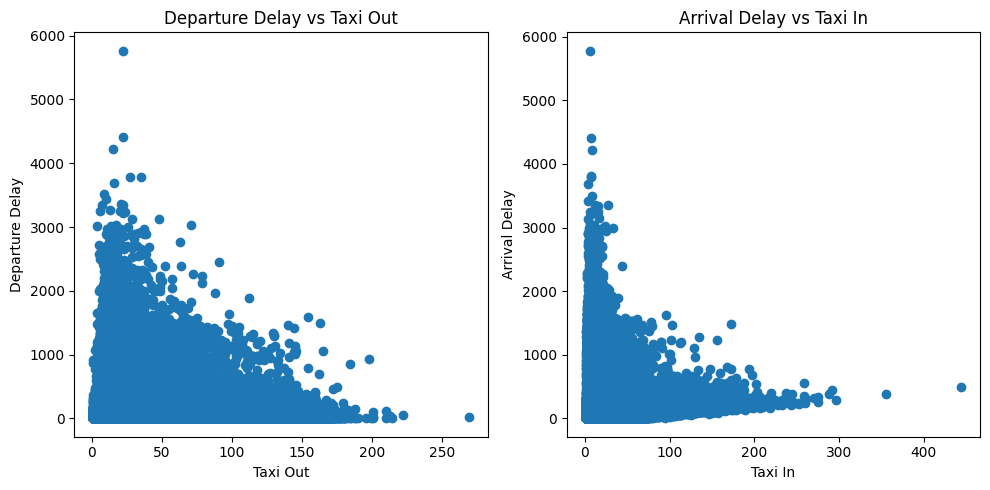

In [18]:
#Graph Taxi times vs delays
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(data['TaxiOut'], data['DepDelayMinutes'])
plt.xlabel('Taxi Out')
plt.ylabel('Departure Delay')
plt.title('Departure Delay vs Taxi Out')
plt.subplot(1, 2, 2)
plt.scatter(data['TaxiIn'], data['ArrDelayMinutes'])
plt.xlabel('Taxi In')
plt.ylabel('Arrival Delay')
plt.title('Arrival Delay vs Taxi In')
plt.tight_layout()
plt.show()

Doesn't seem to matter much how long taxi is in or out as some taxis are under 5 minutes and yet the delay is hours and hours long. Other times the taxi is hours long and the flight isn't delayed at all, not sure if that is an error or not.

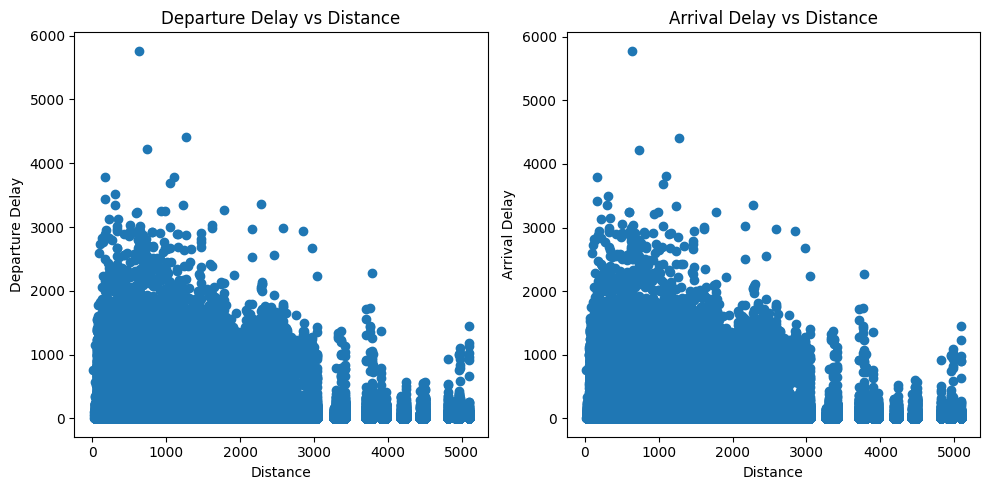

In [19]:
#Graph distance vs delays
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(data['Distance'], data['DepDelayMinutes'])
plt.xlabel('Distance')
plt.ylabel('Departure Delay')
plt.title('Departure Delay vs Distance')
plt.subplot(1, 2, 2)
plt.scatter(data['Distance'], data['ArrDelayMinutes'])
plt.xlabel('Distance')
plt.ylabel('Arrival Delay')
plt.title('Arrival Delay vs Distance')
plt.tight_layout()
plt.show()

Distance doesn't seem to matter as it ranges from everywhere it terms of delays and distance traveled.

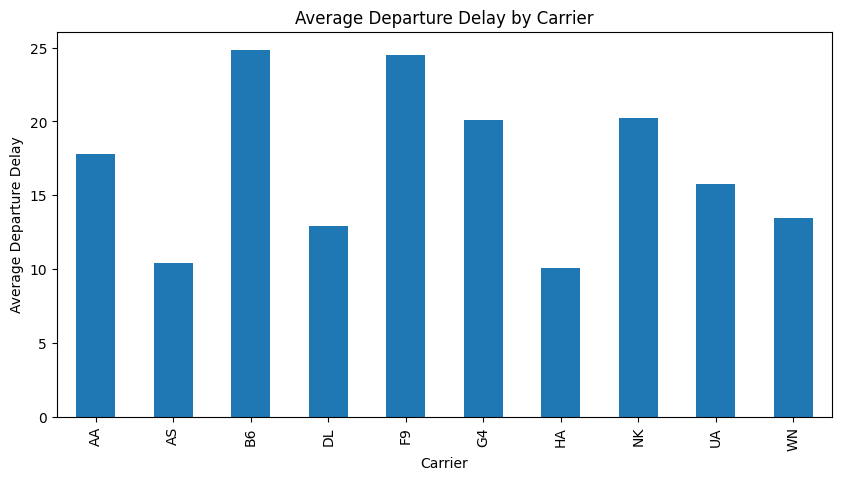

In [ ]:
plt.figure(figsize=(10, 5))
data.groupby('IATA_Code_Marketing_Airline')['DepDelayMinutes'].mean().plot(kind='bar')
plt.title('Average Departure Delay by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Average Departure Delay')
plt.show()

AA, B6, F9, G4, NK, and UA are all airlines where there average departure delay is within our ranges for minor or above delays. Obviously does not mean the other airlines do not have delays that match our criteria but looking at these first would be helpful.

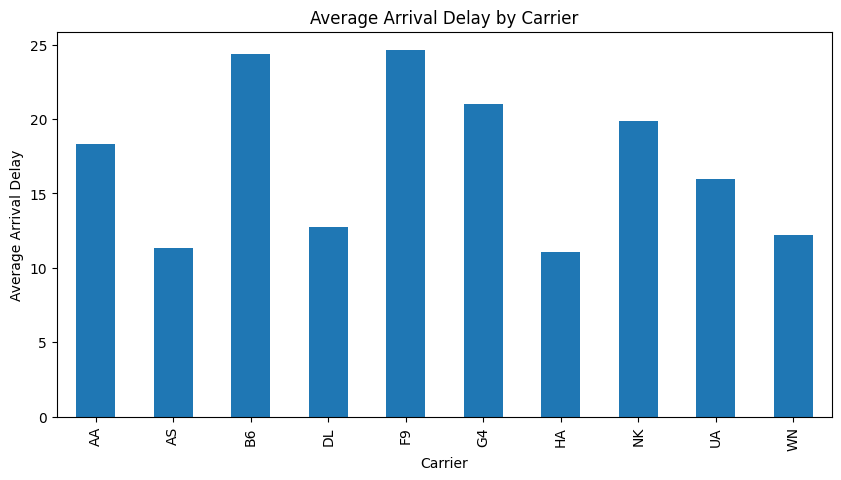

In [50]:
plt.figure(figsize=(10, 5))
data.groupby('IATA_Code_Marketing_Airline')['ArrDelayMinutes'].mean().plot(kind='bar')
plt.title('Average Arrival Delay by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Average Arrival Delay')
plt.show()

AA, B6, F9, G4, NK, and UA once again are in the average range of our delays for minor or above.

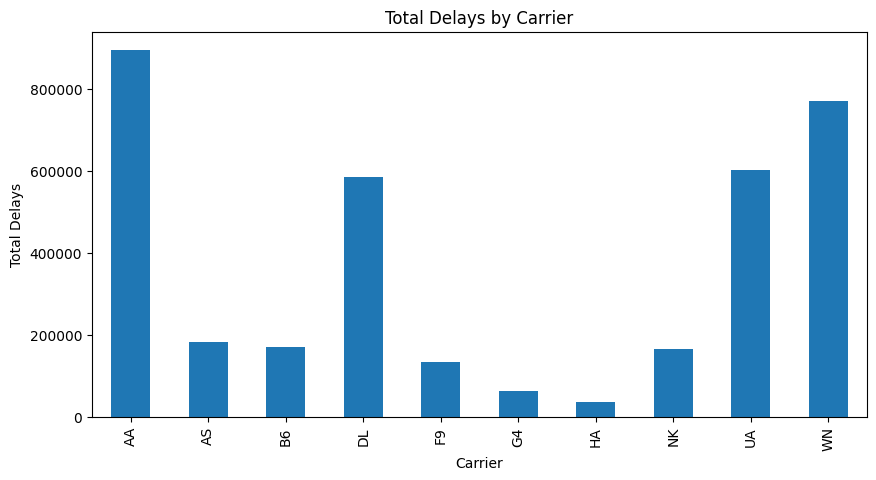

In [66]:
#Total delays by carrier
plt.figure(figsize=(10, 5))
data.groupby('IATA_Code_Marketing_Airline')['TotalDelays'].sum().plot(kind='bar')
plt.title('Total Delays by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Total Delays')
plt.show()

Overall AA, DL, UA, and WN have the most delays. Interesting because WN averages a delay below our threshold of 15 minutes. The others have an average above 15 minutes which means they have a lot of flights 15 or more.

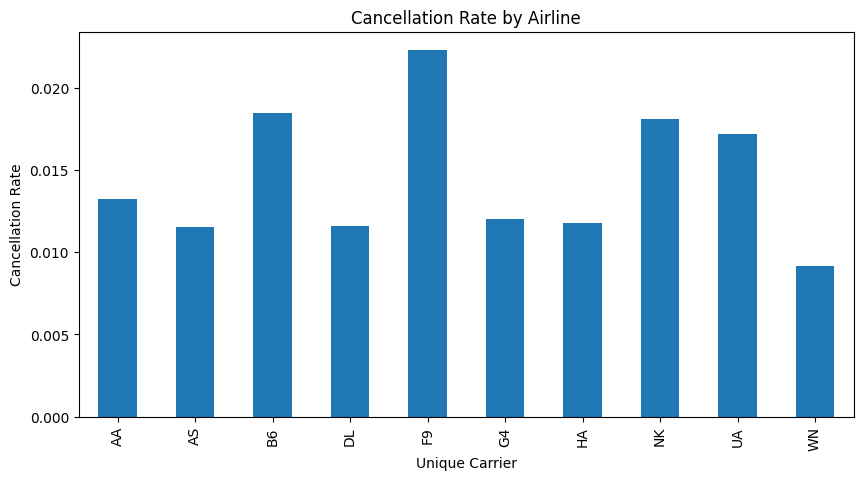

In [36]:
#Graph Airlines vs cancellations
plt.figure(figsize=(10, 5))
data.groupby('IATA_Code_Marketing_Airline')['Cancelled'].mean().plot(kind='bar')
plt.title('Cancellation Rate by Airline')
plt.xlabel('Unique Carrier')
plt.ylabel('Cancellation Rate')
plt.show()

Most are similar rates but B6, F9, NK, and UA are the most likely and match well with the delays as they are the most in regards to that as well.

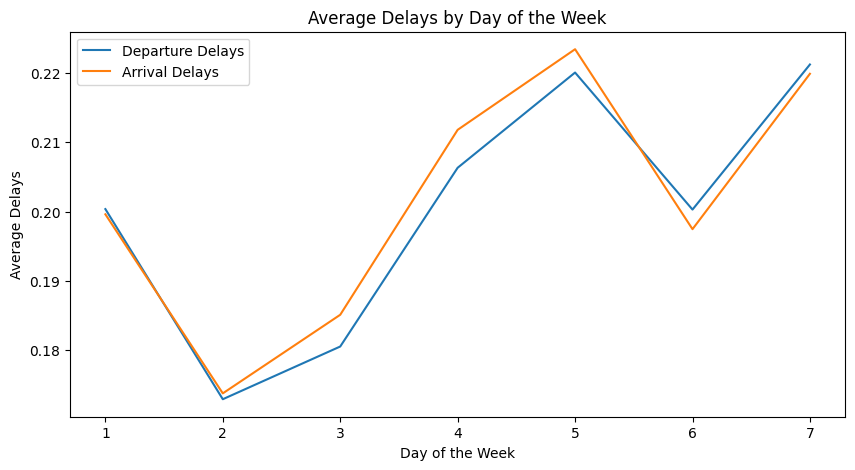

In [38]:
#Delays by day of the week
plt.figure(figsize=(10, 5))
data.groupby('DayOfWeek')['TotalDepDelays'].mean().plot()
data.groupby('DayOfWeek')['TotalArrDelays'].mean().plot()
plt.title('Average Delays by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Delays')
plt.legend(['Departure Delays', 'Arrival Delays'])
plt.show()

Most delays are on Friday and Sunday but closely followed by Monday, Thursday, and Saturday.

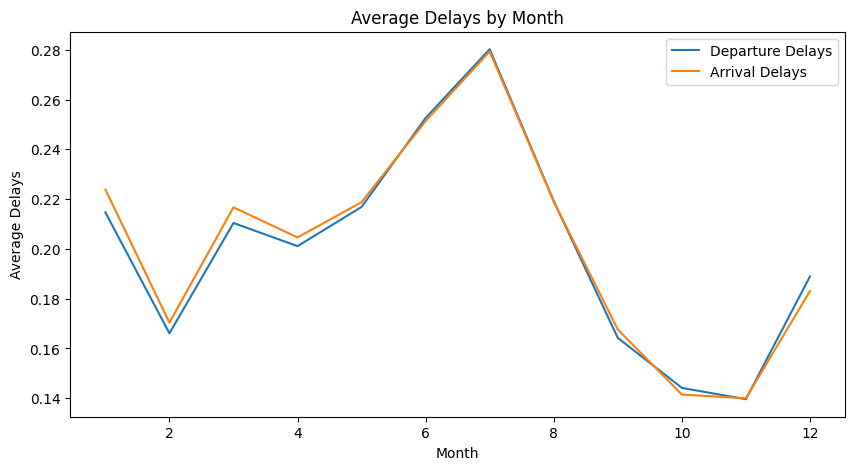

In [51]:
#Delays by month
plt.figure(figsize=(10, 5))
data.groupby('Month')['TotalDepDelays'].mean().plot()
data.groupby('Month')['TotalArrDelays'].mean().plot()
plt.title('Average Delays by Month')
plt.xlabel('Month')
plt.ylabel('Average Delays')
plt.legend(['Departure Delays', 'Arrival Delays'])
plt.show()

July being the most delays by a lot seems random.

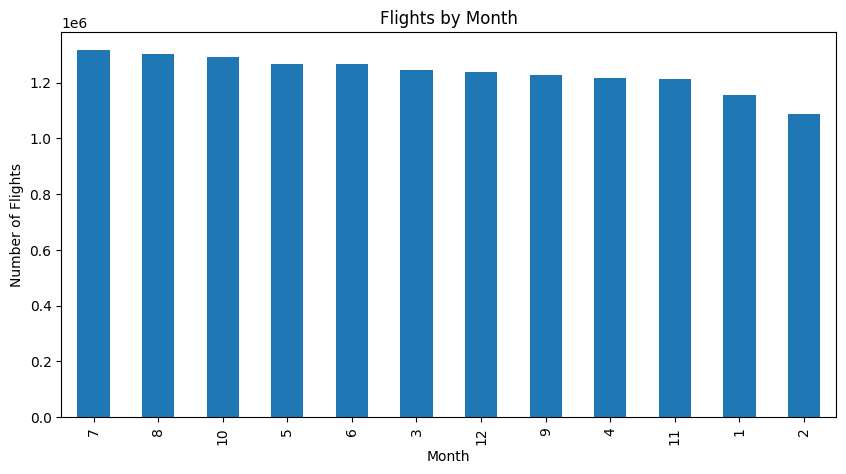

In [67]:
#Flights by month
plt.figure(figsize=(10, 5))
data['Month'].value_counts().plot(kind='bar')
plt.title('Flights by Month')
plt.xlabel('Month')
plt.ylabel('Number of Flights')
plt.show()

July has the most flights overall but not by much so it is weird it has such a big difference in delays.

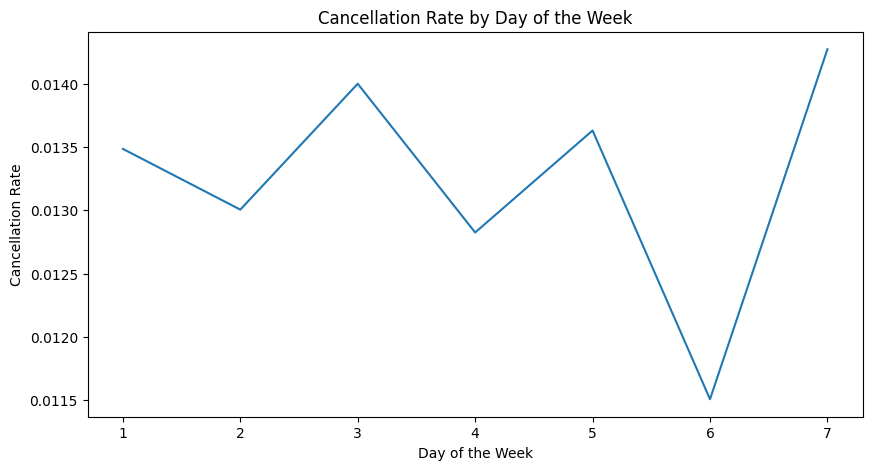

In [53]:
#Cancelled flights by day of the week
plt.figure(figsize=(10, 5))
data.groupby('DayOfWeek')['Cancelled'].mean().plot()
plt.title('Cancellation Rate by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Cancellation Rate')
plt.show()

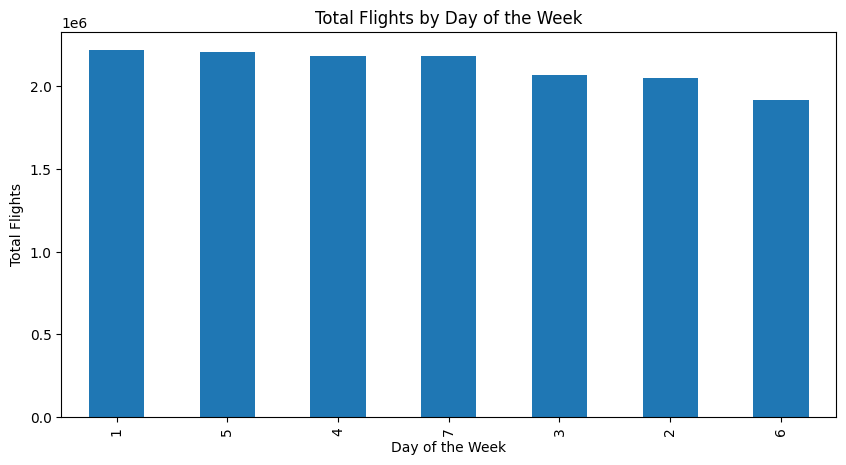

In [63]:
#Total flights by day of the week
plt.figure(figsize=(10, 5))
data['DayOfWeek'].value_counts().plot(kind='bar')
plt.title('Total Flights by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Flights')
plt.show()

Cancellations don't seem to have too much of a correlation for day of the week but it is odd how odd numbers are all the highs of the graph. Saturday being the least likely to be canceled makes sense because it has the least flights overall.

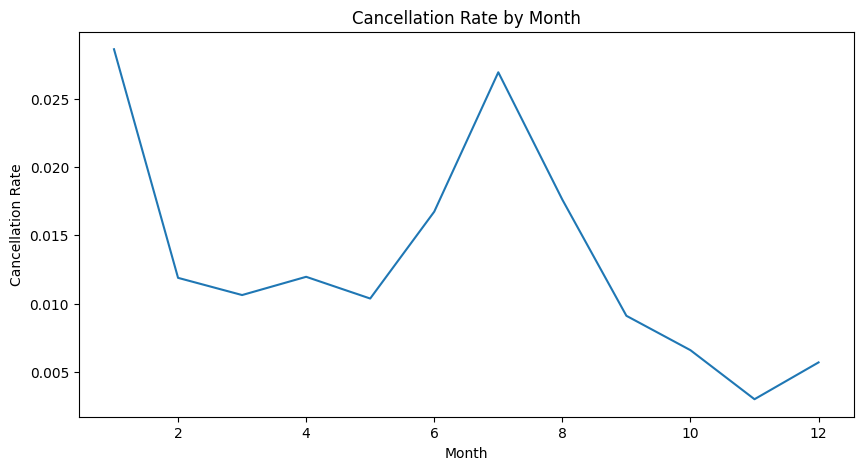

In [52]:
#Cancelled flights by month
plt.figure(figsize=(10, 5))
data.groupby('Month')['Cancelled'].mean().plot()
plt.title('Cancellation Rate by Month')
plt.xlabel('Month')
plt.ylabel('Cancellation Rate')
plt.show()

Most Cancels are in January and July. January makes sense because of weather and holidays but july is confusing, needs to be looked at more.

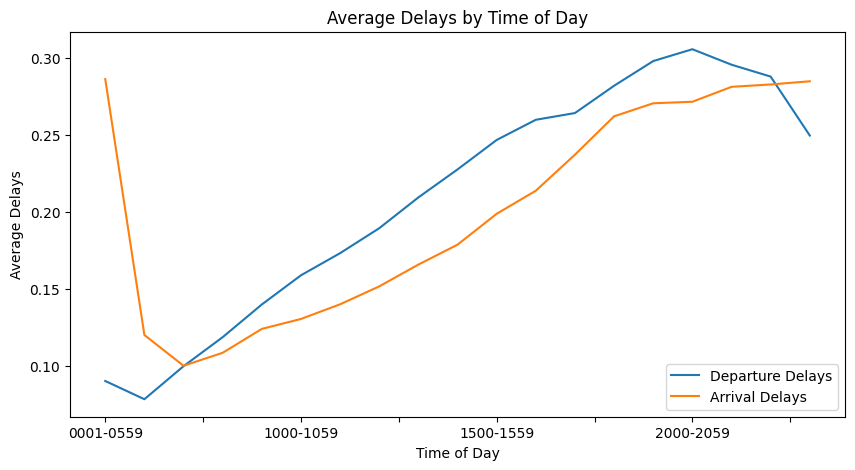

In [54]:
#Delays by time of day
plt.figure(figsize=(10, 5))
data.groupby('DepTimeBlk')['TotalDepDelays'].mean().plot()
data.groupby('ArrTimeBlk')['TotalArrDelays'].mean().plot()
plt.title('Average Delays by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Delays')
plt.legend(['Departure Delays', 'Arrival Delays'])
plt.show()

Most delays are at 8 pm and overall are in the evening. Arrival starts very high and goes down before rising almost linearly. Delays start low and rise at a steady pace which is weird since it means departure delays drop very suddenly from midnight to 12:01 to 5:59.

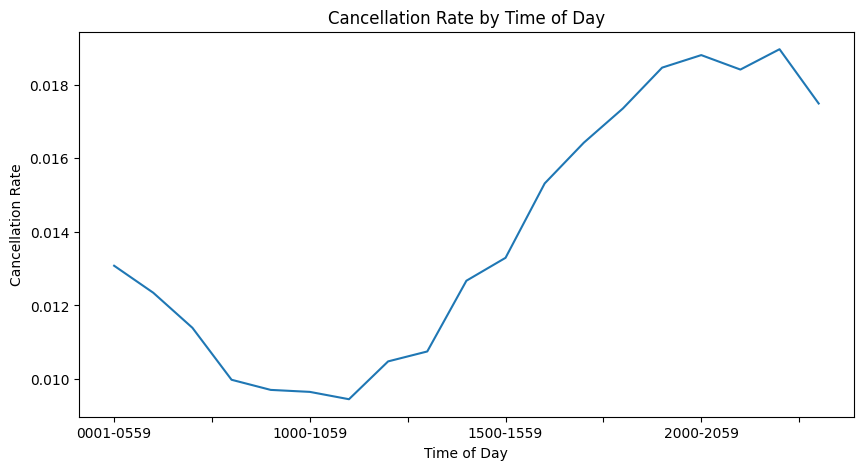

In [55]:
#Cancelled flights by time of day
plt.figure(figsize=(10, 5))
data.groupby('DepTimeBlk')['Cancelled'].mean().plot()
plt.title('Cancellation Rate by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Cancellation Rate')
plt.show()

Flights tend to be cancelled more in the evening around 8 pm too. This means that time of day most likely correlates highly to delays and cancellations and the evening is the most likely from around 4:30 and later.

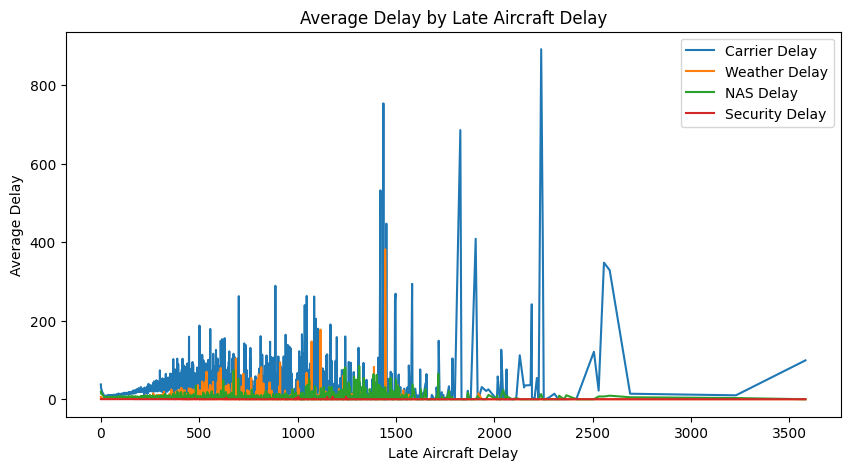

In [68]:
#Graph is late planes cause other delays
plt.figure(figsize=(10, 5))
data.groupby('LateAircraftDelay')['CarrierDelay'].mean().plot()
data.groupby('LateAircraftDelay')['WeatherDelay'].mean().plot()
data.groupby('LateAircraftDelay')['NASDelay'].mean().plot()
data.groupby('LateAircraftDelay')['SecurityDelay'].mean().plot()
plt.title('Average Delay by Late Aircraft Delay')
plt.xlabel('Late Aircraft Delay')
plt.ylabel('Average Delay')
plt.legend(['Carrier Delay', 'Weather Delay', 'NAS Delay', 'Security Delay'])
plt.show()